# Stock Price Prediction Using ARIMA and Exponential Smoothing

In [24]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading the Data

Load the stock price data from a CSV file and display the first few rows to understand the structure of the data.

In [25]:
import yfinance as yf

def download_stock_data():
    """
    Downloads historical stock data for the Nifty 50 index (^NSEI) from Yahoo Finance.
    
    Parameters:
        start (str): Start date in the format 'YYYY-MM-DD'.
        end (str): End date in the format 'YYYY-MM-DD'.
    
    Returns:
        pandas.DataFrame: Historical stock data for the specified date range.
    """
    stock_data = yf.download('^NSEI', start='2010-01-01', end='2024-06-01')
    return stock_data

stock_data = download_stock_data()
stock_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0
2010-01-05,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0
2010-01-06,5278.149902,5310.850098,5260.049805,5281.799805,5281.799805,0
2010-01-07,5281.799805,5302.549805,5244.750000,5263.100098,5263.100098,0
2010-01-08,5264.250000,5276.750000,5234.700195,5244.750000,5244.750000,0
...,...,...,...,...,...,...
2024-05-27,23038.949219,23110.800781,22871.199219,22932.449219,22932.449219,260000
2024-05-28,22977.150391,22998.550781,22858.500000,22888.150391,22888.150391,217900
2024-05-29,22762.750000,22825.500000,22685.449219,22704.699219,22704.699219,269900


In [26]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

Here, We will be using only Close Prices to predict over the model.\
Visualizing the stock data by plotting the close price over time. The plot is displayed using matplotlib.

<Axes: xlabel='Date'>

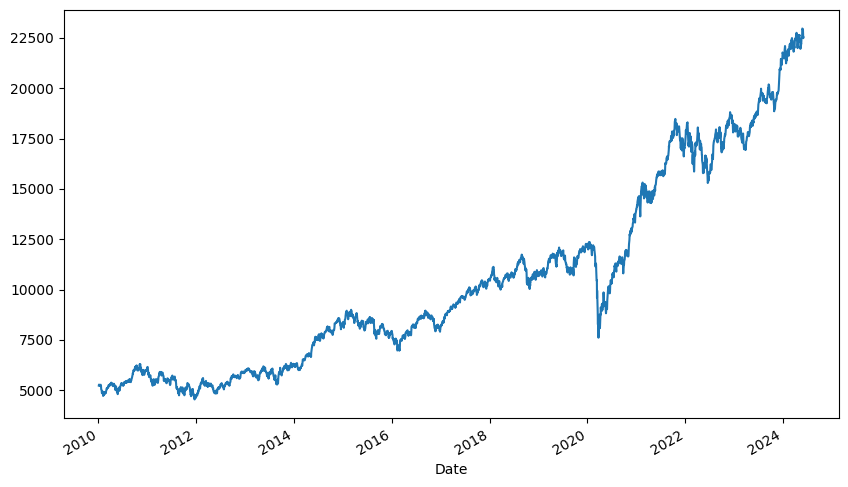

In [27]:
stock_data = stock_data['Close']
stock_data.index = pd.DatetimeIndex(stock_data.index).to_period('D')
stock_data.index = stock_data.index.to_timestamp()
stock_data.plot(figsize=(10, 6))

## Seasonal Decomposition
Seasonal Decomposition is primarily used for time series analysis, and as an analysis tool it can be used to inform forecasting models on your problem.

It provides a structured way of thinking about a time series forecasting problem, both generally in terms of modeling complexity and specifically in terms of how to best capture each of these components in a given model.

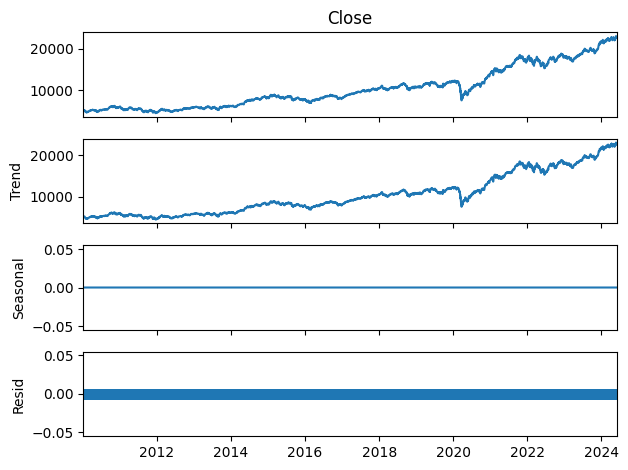

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_seasonal_decomposition(stock_data):
    """
    Plot the seasonal decomposition of the given stock data.

    Parameters:
    stock_data (pandas.DataFrame): The stock data to be decomposed.

    """
    stock_data = stock_data.ffill()
    result = seasonal_decompose(stock_data, model='additive', period=1)
    result.plot()
    plt.show()

plot_seasonal_decomposition(stock_data)

## Splitting Data

In this time series modelling, we'll split the dataset into training, validation and test sets
- Training Set (90%)
- Test Set (30 entries): We are using fixed 30 entries for test set for consistent sample size for final model evaluation.
- Validation Set: The remaining data entries are used for validation set.

In [29]:
def split_data(stock_data):
    """
    Splits the given stock data into training and testing sets.

    Parameters:
    stock_data (list): A list of stock data.

    Returns:
    train (list): The training set, which contains 90% of the stock data.
    valid (list): The validation set, which contains 5% of the stock data.
    test (list): The testing set, which contains the remaining 5% of the stock data.
    """
    train_size = int(len(stock_data) * 0.9)
    valid_size = int(len(stock_data)) - train_size - 30
    test_size = 30
    train = stock_data[:train_size]
    valid = stock_data[train_size:train_size+valid_size]
    test = stock_data[train_size+valid_size:]

    return train, valid, test

train,valid, test = split_data(stock_data)

print("Training set shape:", train.shape)
print("Validation set shape:", valid.shape)
print("Testing set shape:", test.shape)


Training set shape: (3181,)
Validation set shape: (324,)
Testing set shape: (30,)


## Testing Stationarity
We will test for Stationarity, as non-stationary series presents challenges when building time series models.

### Augmented Dickey - Fuller (ADF) Test

This is a common statistical test used to determine wether a series is stationary.\
It assumes the presence of a unit root in the data and attempts to reject this null hypothesis.\
ADF returns 4 values but we will mainly look for only p-value.
A low p-value(<0.05) indicates that we reject null hypothesis and conclude the series is stationary.


In [30]:
from statsmodels.tsa.stattools import adfuller

def perform_adfuller_test(data):
    """
    Perform the Augmented Dickey-Fuller test on the given data.

    Parameters:
    data (array-like): The time series data to be tested.

    Returns:
    p-value (float): The p-value resulting from the test.
    """
    result = adfuller(data)
    print('p-value: %f' % result[1])

perform_adfuller_test(train)


p-value: 0.983157


In [31]:
def find_integeral_term(timeseries):
    """
    Finds the integral term for a given time series data.

    Parameters:
    timeseries (pandas.Series): The input time series data.

    Returns:
    pandas.Series: The differenced time series data.
    int: The number of differencing operations performed.
    """
    data = timeseries.copy()
    d = 0
    while adfuller(data)[1] > 0.05:
        d += 1
        data = data.diff().dropna()
        print('p-value: %f' % adfuller(data)[1])
    return data, d


In [32]:
difference_series, d = find_integeral_term(train)
print('p-value:', adfuller(difference_series)[1])
print('d:', d)

p-value: 0.000000
p-value: 1.4067439196460978e-28
d: 1


<Axes: title={'center': 'Differenced Series'}, xlabel='Date'>

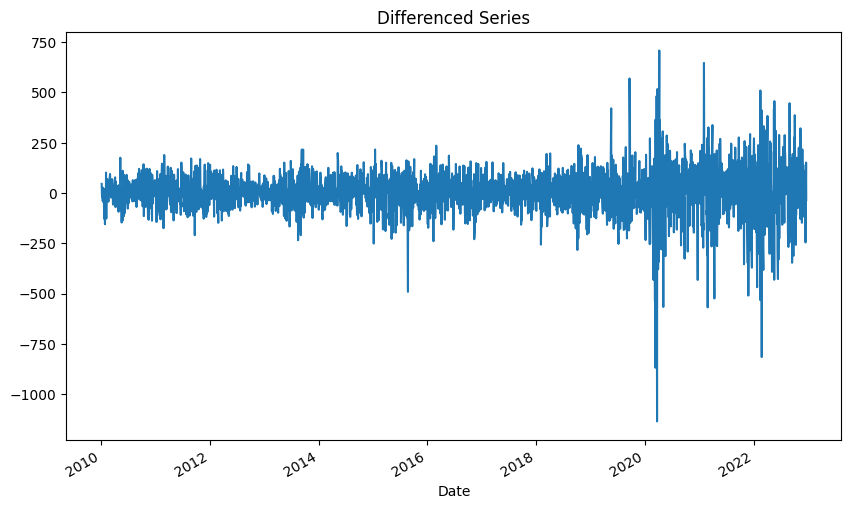

In [33]:
difference_series.plot(figsize=(10, 6),title='Differenced Series')

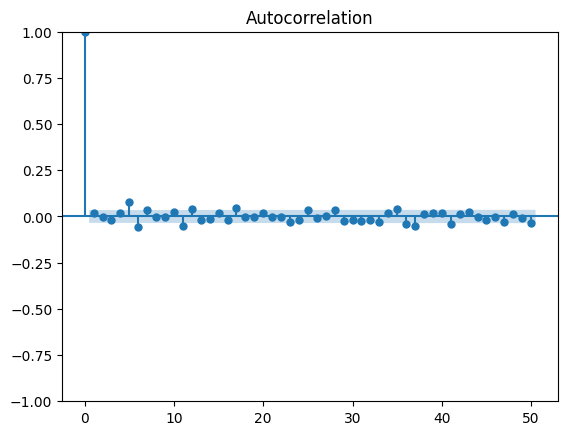

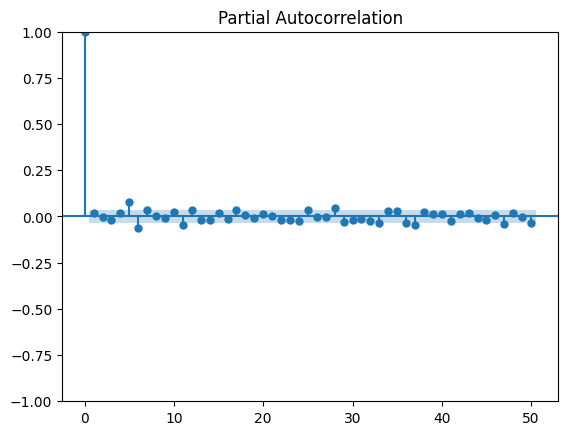

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_autocorrelation(series):
    """
    Plots the autocorrelation and partial autocorrelation of the given series.

    Parameters:
    series (array-like): The series data.

    """
    plot_acf(series, lags=50)
    plot_pacf(series, lags=50)

plot_autocorrelation(difference_series)


In [35]:
model = ARIMA(train, order=(5, d, 5))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3181
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -19319.654
Date:                Fri, 21 Jun 2024   AIC                          38661.308
Time:                        13:02:12   BIC                          38728.019
Sample:                             0   HQIC                         38685.233
                               - 3181                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7472      0.155     -4.823      0.000      -1.051      -0.444
ar.L2         -0.2253      0.221     -1.018      0.309      -0.659       0.208
ar.L3          0.1529      0.248      0.618      0.5

In [36]:
def compute_error(test, predictions):
    """
    Computes the root mean squared error (RMSE) between the test and prediction values.

    Parameters:
    test (numpy.ndarray): The actual test values.
    predictions (numpy.ndarray): The predicted values.

    Returns:
    float: The root mean squared error (RMSE) between the test and prediction values.
    """
    test = test.to_numpy()
    predictions = predictions.to_numpy()
    test = test.reshape(-1, 1)
    predictions = predictions.reshape(-1, 1)
    return np.sqrt(np.mean((predictions - test) ** 2))

In [37]:
def compute_mape(test, predictions):
    """
    Compute the Mean Absolute Percentage Error (MAPE) of predictions compared to the test data.

    Parameters:
    test (numpy.ndarray): The test data.
    predictions (numpy.ndarray): The predicted values.

    Returns:
    float: The MAPE of the predictions as a percentage.
    """
    test = test.to_numpy()
    predictions = predictions.to_numpy()
    test = test.reshape(-1, 1)
    predictions = predictions.reshape(-1, 1)
    return np.mean(np.abs(test - predictions) * 100 / test)

In [38]:
def cross_validate_model(train, valid, num_iter=10):
    """
    Perform cross-validation to optimize the model using the training and validation sets.

    Parameters:
    train (pandas.Series): The training set.
    valid (pandas.Series): The validation set.
    num_iter (int, optional): The number of iterations for cross-validation. Default is 10.

    Returns:
    model_fit (statsmodels.tsa.arima.model.ARIMAResultsWrapper): The fitted ARIMA model.
    rmse_errors (list): List of RMSE errors for each iteration.
    mape_errors (list): List of MAPE errors for each iteration.
    """
    # Initialize lists to store RMSE and MAPE errors
    rmse_errors = []
    mape_errors = []

    # Initialize the fitted model
    model_fit = None

    # Determine the step size for each iteration
    step = len(train) // num_iter

    # Get the size of the validation set
    valid_size = len(valid)

    # Perform cross-validation
    for i in range(step, len(train)+1, step):
        # Split the training set into a window
        train_window = train[:i]

        # Determine the validation window based on the current iteration
        if i + valid_size > len(train):
            valid_window = valid
        else:
            valid_window = train[i:i+valid_size]

        # Fit an ARIMA model to the training window
        model = ARIMA(train_window, order=(1, d, 1))
        model_fit = model.fit()

        # Make predictions on the validation window
        predictions = model_fit.forecast(steps=len(valid_window))

        # Compute RMSE and MAPE errors
        rmse = compute_error(valid_window, predictions)
        mape = compute_mape(valid_window, predictions)

        # Append errors to the respective lists
        rmse_errors.append(rmse)
        mape_errors.append(mape)
        
    combined = pd.concat([train, valid], axis=0)
    model = ARIMA(combined, order=(5, d, 5))
    model_fit = model.fit()

    # Return the fitted model and error lists
    return model_fit, rmse_errors, mape_errors


In [39]:
num_iterations = range(10,51,5)
rmse_errors = []
mape_errors = []
# figures = []
model_fit = None

for num_iter in num_iterations:
    model_fit, rmse_error, mape_error = cross_validate_model(train, valid, num_iter)
    rmse_errors.append(np.mean(rmse_error))
    mape_errors.append(np.mean(mape_error))
    print(f'Number of Iterations: {num_iter}\t RMSE: {round(np.mean(rmse_error),2)}\t MAPE: {round(np.mean(mape_error),2)}')



Number of Iterations: 10	 RMSE: 1568.53	 MAPE: 11.64
Number of Iterations: 15	 RMSE: 1460.27	 MAPE: 11.34
Number of Iterations: 20	 RMSE: 1357.57	 MAPE: 10.09
Number of Iterations: 25	 RMSE: 1429.93	 MAPE: 10.83
Number of Iterations: 30	 RMSE: 1472.69	 MAPE: 11.21
Number of Iterations: 35	 RMSE: 1381.1	 MAPE: 10.47
Number of Iterations: 40	 RMSE: 1346.7	 MAPE: 10.34
Number of Iterations: 45	 RMSE: 1340.02	 MAPE: 10.1
Number of Iterations: 50	 RMSE: 1358.52	 MAPE: 10.58


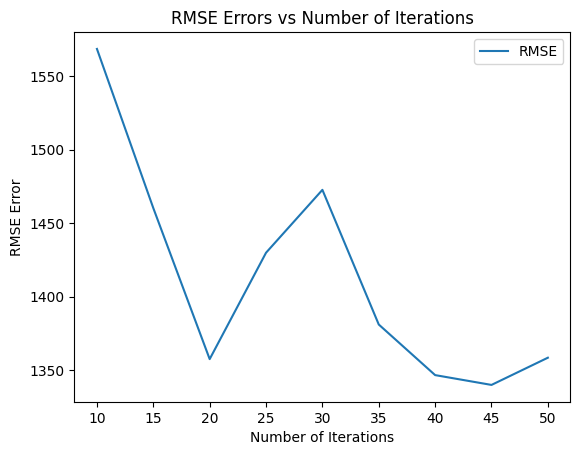

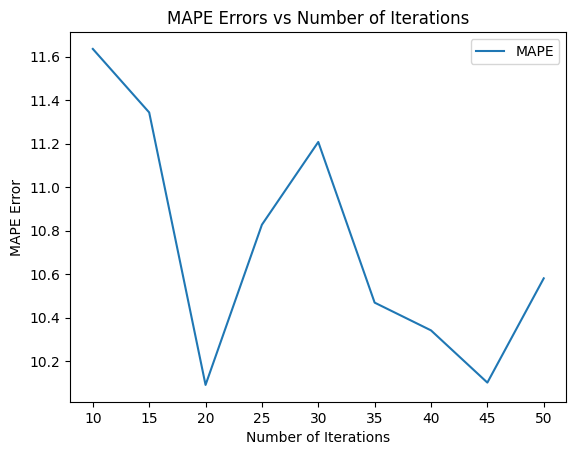

In [40]:
# Plot RMSE error
plt.plot(num_iterations, rmse_errors, label='RMSE')
plt.xlabel('Number of Iterations')
plt.ylabel('RMSE Error')
plt.title('RMSE Errors vs Number of Iterations')
plt.legend()
plt.show()

# Plot MAPE error
plt.plot(num_iterations, mape_errors, label='MAPE')
plt.xlabel('Number of Iterations')
plt.ylabel('MAPE Error')
plt.title('MAPE Errors vs Number of Iterations')
plt.legend()
plt.show()

In [41]:
num_iter = 20
model_fit, rmse_error, mape_error = cross_validate_model(train, valid, num_iter)
print(f' RMSE: {np.mean(rmse_error)}\t MAPE: {np.mean(mape_error)}')

 RMSE: 1357.574490177133	 MAPE: 10.091377213716278


In [42]:
test_predictions = model_fit.forecast(steps=len(test))

In [43]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 3505
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -21373.074
Date:                Fri, 21 Jun 2024   AIC                          42768.147
Time:                        13:03:41   BIC                          42835.925
Sample:                             0   HQIC                         42792.335
                               - 3505                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7275      0.152     -4.802      0.000      -1.024      -0.431
ar.L2         -0.2769      0.211     -1.313      0.189      -0.690       0.136
ar.L3          0.3196      0.220      1.451      0.147      -0.112       0.751
ar.L4          0.1595      0.212      0.751      0.452      -0.257       0.576
ar.L5          0.3999      0.110      3.637      0.000       0.184       0.615
ma.L1          0.7565      0.155      4.890      0.000       0.453       1.060
ma.L2          0.3089      0.220      1.406      0.160      -0.122       0.740
ma.L3         -0.3374      0.231     -1.464      0.143      -0.789       0.114
ma.L4         -0.1491      0.222     -0.671      0.503      -0.585       0.287
ma.L5         -0.3400      0.118     -2.889      0.004      -0.571      -0.109
sigma2      1.169e+04    141.040     82.915      0.000    1.14e+04     1.2e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11333.78
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               6.73   Skew:                            -0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

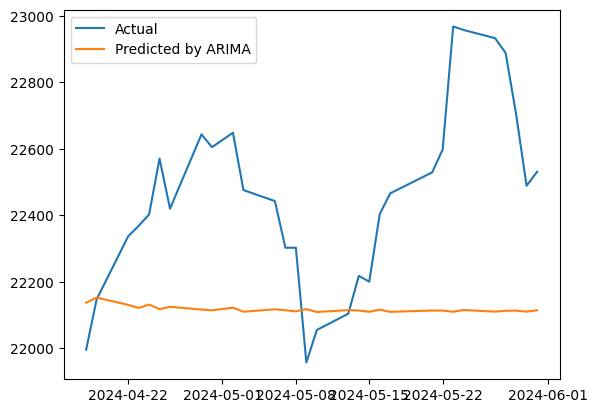

In [61]:
# test.index = test.index.to_timestamp()
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, test_predictions, label='Predicted by ARIMA')
plt.legend()

Compute Root Mean Square Error and  Mean Absolute Percentage Error for final Prediction

In [45]:
compute_test = compute_error(test, test_predictions)
compute_mape = compute_mape(test, test_predictions)
print('RMSE:', compute_test)
print('MAPE:', compute_mape)

RMSE: 433.83279509530894
MAPE: 1.6028044725036754


## Exponential Smoothing

### Simple or Single Exponential Smoothing
Single exponential smoothing is a method used for forecasting time series data where there is no trend or seasonality. It involves assigning exponentially decreasing weights to past observations, with the most recent data points receiving higher weights.

### Double Exponential Smoothing
Double exponential smoothing is a method used for forecasting time series data that includes a trend component. It extends single exponential smoothing by incorporating a second smoothing parameter to account for the trend in the data.

### Triple Exponential Smoothing
Triple exponential smoothing, also known as Holt-Winters smoothing, is a forecasting method used for time series data that exhibits both trend and seasonality.

- As we seen in seasonal decompose above our data has trend but no seasonality.
- So we will continue with Double Exponential Smoothing.


In [59]:
from statsmodels.tsa.holtwinters import Holt

combined = pd.concat([train, valid], axis=0)
exponential_model = Holt(combined)
exponential_model_fit = exponential_model.fit()
forecast = exponential_model_fit.forecast(len(test))

Text(0, 0.5, 'Stock Price')

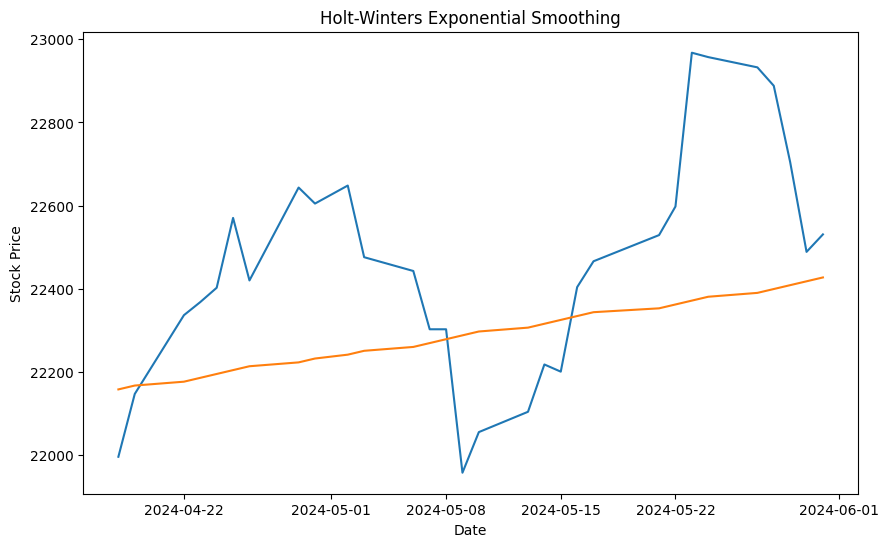

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, forecast, label='Predicted')
plt.title('Holt-Winters Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Stock Price')

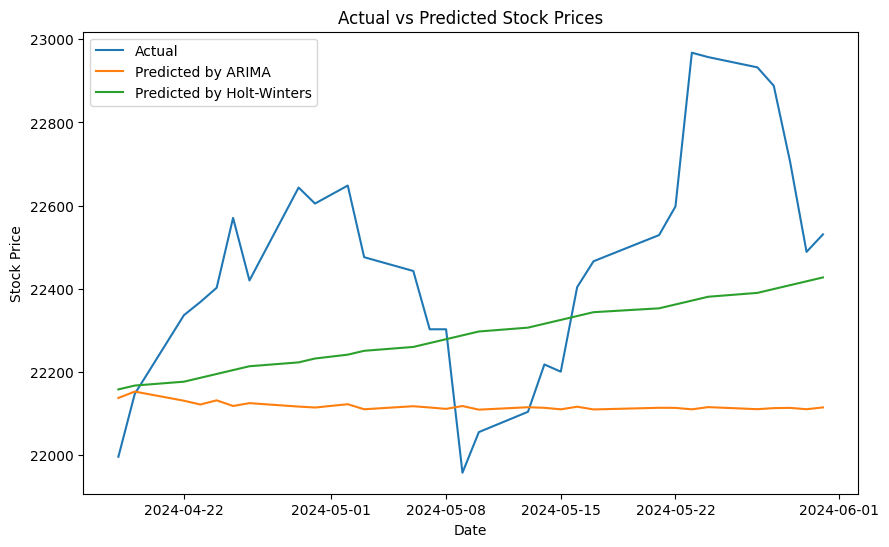

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, test_predictions, label='Predicted by ARIMA')
plt.plot(test.index, forecast, label='Predicted by Holt-Winters')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()